
# Image Classification

Building a machine learning model to solve Image Classification using the PyTorch framework.<br>
Image Classification is one of the basic pattern recognition exercises. <br>
Using Image files as its input, a model trained for Image classification will split a set of images into a given number of classes. <br>
<br>
This Notebook has been generated automatically using the JupyterLab extension ***MLProvCodeGen***.
<br>
The original Source Code is from this application https://github.com/jrieke/traingenerator <br>
Made by: https://www.jrieke.com/ Twitter: https://twitter.com/jrieke


### Installs
Install required packages before running

In [1]:
#pip install numpy===1.22.2 ipywidgets===7.6.5 torch===1.10.2 torchvision===0.11.3 pytorch-ignite===0.4.6 pytorch-lightning===1.5.10 gputil===1.4.0 psutil===5.9.0 py-cpuinfo===8.0.0 prov===2.0.0 pydot===1.4.2 --user
#torch currently not supported with python 3.10, downgrading to python 3.9.7 possibly required


### Imports

In [2]:
import numpy as np
import torch
import ipywidgets as widgets
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision as torchvision
from torchvision import models, datasets, transforms
import ignite as pytorch_ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ClassificationReport
import pytorch_lightning
from pytorch_lightning import seed_everything
import GPUtil
import psutil
import cpuinfo
import platform
import datetime
from datetime import date
import time
import json
import webbrowser
import IPython
from IPython.display import display, Image
import prov
from prov.model import ProvDocument
from prov.dot import prov_to_dot
import os
from prov.model import ProvDocument, Namespace, Literal, PROV, Identifier

### Provenance Data

In [3]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

d1 = ProvDocument()
d1.add_namespace('prov', 'http://www.w3.org/ns/prov#')
d1.add_namespace('ex', 'https://github.com/TarekAlMustafa/MLProvCodeGen1.0/')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('p-plan', 'http://purl.org/net/p-plan')

e_MLProvCodeGen = d1.entity(
        'ex:MLProvCodeGen',(
            ('prov:type', PROV['Plan']),
))
ag_author = d1.agent(
        'ex:Tarek Al Mustafa',(
            ('prov:type', PROV['Person']),
            ('foaf:givenName', 'Tarek Al Mustafa'),
            ('foaf:mbox', '<tarek.almustafa@uni-jena.de>'),
            ('prov:role', 'Author'),
))
kernellist = !jupyter kernelspec list
e_notebook = d1.entity(
        'ex:notebook',(
            ('ex:programming_language','Python'),
            ('ex:programming_language_version', cpuinfo.get_cpu_info()['python_version']),
            ('ex:kernel','python3(ipykernel)'),
            ('prov:type', PROV['File']),
            ('ex:fileformat', '.ipynb'),
            ('ex:name', 'MulticlassClassification.ipynb'),
            ('ex:creation_date', str(date.today())),
            ('ex:last_modified', 'TODO'),
))
e_notebook.add_asserted_type('prov:Collection')
d1.wasAttributedTo(e_notebook, ag_author)
a_generateNotebook = d1.activity('ex:GenerateNotebook')
d1.wasAssociatedWith(a_generateNotebook, ag_author, plan=e_MLProvCodeGen)
d1.wasGeneratedBy(e_notebook, a_generateNotebook)

#set_experimentinfo
e_experimentinfo = d1.entity('ex:Cell Experiment Info', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setexperimentinfo = d1.activity('ex:set_experiment_info()')
a_setdate = d1.activity('ex:date.today()')

d1.wasStartedBy(a_setexperimentinfo,e_experimentinfo, time=datetime.datetime.now())
d1.wasInformedBy(a_setexperimentinfo, a_setdate)  
d1.hadMember(e_notebook, e_experimentinfo)
e_experimentinfo_data = d1.entity(
    'ex:Experiment Info Data',(
        ('ex:title', 'Image Classification'),
        ('ex:creation_date', str(date.today())),
        ('ex:task_type', 'ImageClassification_pytorch'),
))
d1.wasGeneratedBy(e_experimentinfo_data, a_setexperimentinfo)

#set_hardware_info()
uname = platform.uname()
sysInfo = str(uname.system +' '+ uname.release +' Version: '+ uname.version +' Machine: '+ uname.machine)
    
svmem = psutil.virtual_memory()

GPUs = GPUtil.getGPUs()
gpuList = []
for gpu in GPUs:
    gpu_id = gpu.id
    gpu_name = gpu.name
    gpuList.append((gpu_id , gpu_name))

        
e_hardwareinfo = d1.entity('ex:Cell Hardware Info', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_sethardwareinfo = d1.activity('ex:set_hardware_info()')
a_platform_uname = d1.activity('ex:platform.uname()')
a_cpuinfo = d1.activity('ex:cpuinfo.get_cpu_info()')
a_svmemtotal = d1.activity('ex:svmem.total')
a_getsize = d1.activity('ex:get_size(svmem.total)')
a_GPUtilgetGPU = d1.activity('ex:GPUtil.getGPUs()')
d1.wasStartedBy(a_sethardwareinfo, e_hardwareinfo, time=datetime.datetime.now())
d1.wasInformedBy(a_sethardwareinfo, a_platform_uname)
d1.wasInformedBy(a_sethardwareinfo, a_cpuinfo)
d1.wasInformedBy(a_sethardwareinfo, a_svmemtotal)
d1.wasInformedBy(a_svmemtotal, a_getsize)
d1.wasInformedBy(a_sethardwareinfo, a_GPUtilgetGPU)
d1.hadMember(e_notebook, e_hardwareinfo)
e_hardwareinfo_data = d1.entity(
    'ex:Hardware Info Data',(
        ('ex:CPU', cpuinfo.get_cpu_info()['brand_raw']),
        ('ex:RAM',  get_size(svmem.total)),
        ('ex:Operating System', sysInfo),
        ('ex:GPUs', str(gpuList)),
))
d1.wasGeneratedBy(e_hardwareinfo_data, a_sethardwareinfo)

#set_packages
cpuInfo_version = !pip list | grep -i py-cpuinfo
pytorch_model_summary_version = !pip list | grep -i pytorch-model-summary


e_packages = d1.entity('ex:Cell Packages', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setpackages = d1.activity('ex:set_packages()', )
a_getVersion = d1.activity('ex:{package_name}.__version__')
a_getVersion_py_cpuinfo = d1.activity('ex:!pip list | grep -i py-cpuinfo')
a_getVersion_pytorch_model_summary = d1.activity('ex:!pip list | grep -i pytorch-model-summary')
d1.wasStartedBy(a_setpackages, e_packages, time=datetime.datetime.now())
d1.wasInformedBy(a_setpackages,a_getVersion)
d1.wasInformedBy(a_setpackages,a_getVersion_py_cpuinfo)
d1.wasInformedBy(a_setpackages,a_getVersion_pytorch_model_summary)
d1.hadMember(e_notebook, e_packages)

e_packages_data = d1.entity(
    'ex:Packages Data',(
        ('ex:numpy', np.__version__),
    ('ex:ipywidgets', widgets.__version__),
    ('ex:torch', torch.__version__),
    ('ex:torchvision', torchvision.__version__),
    ('ex:pytorch-ignite', pytorch_ignite.__version__),
    ('ex:pytorch-lightning',pytorch_lightning.__version__),
    ('ex:gputil', GPUtil.__version__),
    ('ex:psutil', psutil.__version__),
    ('ex:py-cpuinfo', cpuInfo_version[0]),
    ('ex:prov', prov.__version__), 
))
d1.wasGeneratedBy(e_packages_data, a_setpackages)

<ProvGeneration: (ex:Packages Data, ex:set_packages())>

### Data Ingestion

In [4]:
starttime = datetime.datetime.now()


dataset = getattr(datasets, 'FakeData')
training_dataset = dataset(image_size = (3, 224, 224))
testing_dataset = dataset(image_size = (3, 224, 224))
endtime = datetime.datetime.now()
executionTime = endtime-starttime

dataInfo = training_dataset.__len__
root_location = 'fake data - root does not exist'

e_dataingestion = d1.entity('ex:Cell Data Ingestion', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))


a_setdataingestion = d1.activity('ex:set_data_ingestion()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})
d1.wasStartedBy(a_setdataingestion, e_dataingestion)
d1.hadMember(e_notebook, e_dataingestion)
e_dataingestion_data = d1.entity(
    'ex:Data Ingestion Data',(
        ('ex:data_format', 'Public dataset'),
        ('ex:dataset_id', 'FakeData'),
		('ex:feature_classes', 10),
		('ex:training_samples',  training_dataset.__len__()),
		('ex:testing_samples', testing_dataset.__len__()),
		('ex:root_location', root_location),
))
d1.wasGeneratedBy(e_dataingestion_data, a_setdataingestion)
a_splitlines = ('ex:str(dataInfo).splitlines()[2]')
a_getlength = d1.activity('ex:{dataset}.__len__()')
d1.wasInformedBy(a_setdataingestion, a_getlength)


<ProvCommunication: (ex:set_data_ingestion(), ex:{dataset}.__len__())>

### Data Preparation

In [5]:
starttime = datetime.datetime.now()
transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
#transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale to RGB
])

endtime = datetime.datetime.now()
executionTime = endtime-starttime

dataInfo = training_dataset.__len__
transform_method = str(dataInfo).splitlines()[4:11]

e_datapreparation = d1.entity('ex:Cell Data Preparation', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setdatapreparation = d1.activity('ex:set_data_preparation()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})

d1.wasStartedBy(a_setdatapreparation, e_datapreparation)
d1.hadMember(e_notebook, e_datapreparation)
e_datapreparation_data = d1.entity(
    'ex:Data Preparation Data',(
        ('ex:preprocessing', str(transform_method)),
))
d1.wasGeneratedBy(e_datapreparation_data, a_setdatapreparation)
d1.wasInfluencedBy(e_datapreparation, e_dataingestion_data)
d1.wasInformedBy(a_splitlines, a_getlength)
d1.wasInformedBy(a_setdatapreparation, a_splitlines)


<ProvCommunication: (ex:set_data_preparation(), ex:str(dataInfo).splitlines()[2])>

### Data Segregation

In [6]:
starttime = datetime.datetime.now()
# Set up device.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
print_every = 1  # batches
# Wrap in data loader.
dataset = getattr(datasets, 'FakeData')
training_dataset = dataset(size = 255, image_size = (3, 224, 224), num_classes = 256, transform = transform)
testing_dataset = dataset(size = 255, image_size = (3, 224, 224), num_classes = 256, transform = transform)

if use_cuda:
    kwargs = {"pin_memory": True, "num_workers": 1}
else:
    kwargs = {}

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False, **kwargs)
val_loader = None

endtime = datetime.datetime.now()
executionTime = endtime-starttime
e_datasegregation = d1.entity('ex:Cell Data Segregation', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setdatasegregation = d1.activity('ex:set_data_segregation()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})
d1.wasStartedBy(a_setdatasegregation, e_datasegregation)
d1.hadMember(e_notebook, e_datasegregation)
e_datasegregation_data = d1.entity(
    'ex:Data Segregation Data',(
        ('ex:training_dataset', str(training_dataset.__len__)),
		('ex:testing_dataset', str(testing_dataset.__len__)), 
))
d1.wasGeneratedBy(e_datasegregation_data, a_setdatasegregation)
d1.wasInfluencedBy(e_datasegregation, e_datapreparation_data)
d1.wasInformedBy(a_setdatasegregation, a_getlength)


<ProvCommunication: (ex:set_data_segregation(), ex:{dataset}.__len__())>

### Model

In [7]:
starttime = datetime.datetime.now()
# Set up model, loss, optimizer.
lr = 0.001
model = models.resnet18(pretrained=0)
num_classes = 1000
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


endtime = datetime.datetime.now()
executionTime = endtime-starttime

e_modelparameters = d1.entity('ex:Cell Model Parameters', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setmodelparameters = d1.activity('ex:set_model_parameters()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})
d1.wasStartedBy(a_setmodelparameters, e_modelparameters)
d1.hadMember(e_notebook, e_modelparameters)
e_modelparameters_data = d1.entity(
    'ex:Model Parameters Data',(
        ('ex:model_name', 'resnet18'),
		('ex:save_checkpoint', 0),
		('ex:pretrained', 0),
		('ex:gpu_enable', 1),
		#('ex:modelParameters', str(model)),
		('ex:loss_function', 'CrossEntropyLoss'),
		('ex:optimizer', 'Adam'),
		('ex:optimizer_learning_rate', lr),
		('ex:num_classes', 1000),  
))
d1.wasGeneratedBy(e_modelparameters_data, a_setmodelparameters)
d1.wasInfluencedBy(e_modelparameters, e_datasegregation_data)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [8]:
starttime = datetime.datetime.now()
seed_everything(2, workers=True)
def set_train_log(log: str, value: str):
    log+= value
    return log

num_epochs = 3
epoch_log = ""
# Set up pytorch-ignite trainer and evaluator.
trainer = create_supervised_trainer(
    model,
    optimizer,
    loss_func,
    device=device,
    deterministic=True
)
metrics = {
    "report": ClassificationReport(),
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}
evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")
    train_log = set_train_log('', (f"Epoch {trainer.state.epoch} / {num_epochs} average results: "))

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )
        
        log = set_train_log(train_log, (
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        ))
        return log

    # Train data.
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)
    
    # Val data.
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # Test data.
    if test_loader:
        evaluator.run(test_loader)
        log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()
    return train_log

# Start training.
train_log = trainer.run(train_loader, max_epochs=num_epochs)

print(train_log)
endtime = datetime.datetime.now()
executionTime = endtime-starttime

e_training = d1.entity('ex:Cell Training', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_settraining = d1.activity('ex:set_training()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})
d1.wasStartedBy(a_settraining, e_training)
d1.hadMember(e_notebook, e_training)
e_training_data = d1.entity(
    'ex:Training Data',(
        ('ex:batch_size', batch_size),    
		('ex:epochs', num_epochs),
		('ex:train_metrics', str(train_log)),
		('ex:print_progress', 1),
		('ex:seed', 2),
))
d1.wasGeneratedBy(e_training_data, a_settraining)
d1.wasInfluencedBy(e_training, e_modelparameters_data)

Global seed set to 2


Epoch 1 / 3, batch 1 / 2: loss: 7.086
Epoch 1 / 3, batch 2 / 2: loss: 6.833
Epoch 1 / 3 average results: 
train: loss: 6.682, accuracy: 0.008
test:  loss: 6.682, accuracy: 0.008

--------------------------------------------------------------------------------

Epoch 2 / 3, batch 1 / 2: loss: 4.689
Epoch 2 / 3, batch 2 / 2: loss: 3.871
Epoch 2 / 3 average results: 
train: loss: 6.144, accuracy: 0.020
test:  loss: 6.144, accuracy: 0.020

--------------------------------------------------------------------------------

Epoch 3 / 3, batch 1 / 2: loss: 2.544
Epoch 3 / 3, batch 2 / 2: loss: 1.894
Epoch 3 / 3 average results: 
train: loss: 5.540, accuracy: 0.016
test:  loss: 5.540, accuracy: 0.016

--------------------------------------------------------------------------------

State:
	iteration: 6
	epoch: 3
	epoch_length: 2
	max_epochs: 3
	output: 1.8938710689544678
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 872583848

<ProvInfluence: (ex:Cell Training, ex:Model Parameters Data)>

### Evaluation

In [9]:
starttime = datetime.datetime.now()
endtime = datetime.datetime.now()
executionTime = endtime-starttime

e_evaluation = d1.entity('ex:Cell Evaluation', (
    ('ex:type', 'notebook_cell'),
    ('ex:type', 'p-plan:step'),
))
a_setevaluation = d1.activity('ex:set_evaluation()', startTime=starttime, endTime=endtime, other_attributes={'prov:executionTime': str(executionTime)})
e_evaluation_data = d1.entity(
    'ex:Evaluation Data',(
        ('ex:accuracy', evaluator.state.metrics['accuracy']),
		('ex:loss', evaluator.state.metrics['loss']),
))
d1.wasStartedBy(a_setevaluation, e_evaluation)
d1.hadMember(e_notebook, e_evaluation)
d1.wasGeneratedBy(e_evaluation_data, a_setevaluation)
d1.wasInfluencedBy(e_evaluation, e_training_data)

<ProvInfluence: (ex:Cell Evaluation, ex:Training Data)>

### Generate Provenance Data

Button(description='Open Image File', style=ButtonStyle())

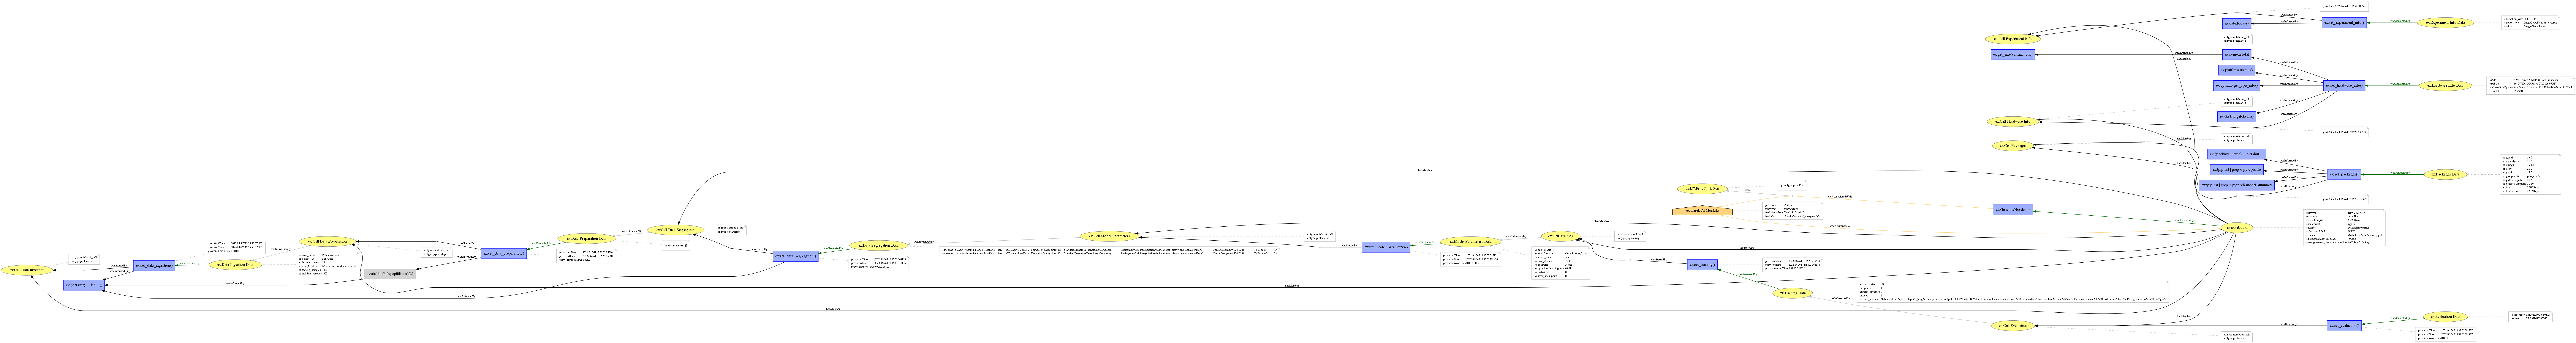

In [10]:
#add visualization to PATH
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
ProvenanceNameImage = ('Provenance_ImageClassification_' + timestring + '.png')

dot = prov_to_dot(d1, direction='RL')
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/extension/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

### Write Provenance Data

In [11]:
ProvenanceName = ('Provenance_ImageClassification_' + timestring + '.json')

with open('../GeneratedProvenanceData/'+ProvenanceName, 'w') as prov_file:
    prov_file.write(d1.serialize(indent=2))

### Open Provenance Data

In [12]:
provenance_open = widgets.Button(description = 'Open Provenance Data File')
display(provenance_open)

def on_button_clicked(b):
    provenance_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/extension/GeneratedProvenanceData/'+ProvenanceName)

provenance_open.on_click(on_button_clicked)

Button(description='Open Provenance Data File', style=ButtonStyle())